# **Libraries**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

from imblearn.combine import SMOTEENN
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Collection and Pre-Processing**

In [ ]:
import pandas as pd

data2 = pd.read_csv("dataset.csv")
print("Shape:", data2.shape)
print(data2.head())
print(data2.info())


Shape: (43400, 12)
      id  gender   age  hypertension  heart_disease ever_married  \
0  30669    Male   3.0             0              0           No   
1  30468    Male  58.0             1              0          Yes   
2  16523  Female   8.0             0              0           No   
3  56543  Female  70.0             0              0          Yes   
4  46136    Male  14.0             0              0           No   

      work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0      children          Rural              95.12  18.0              NaN   
1       Private          Urban              87.96  39.2     never smoked   
2       Private          Urban             110.89  17.6              NaN   
3       Private          Rural              69.04  35.9  formerly smoked   
4  Never_worked          Rural             161.28  19.1              NaN   

   stroke  
0       0  
1       0  
2       0  
3       0  
4       0  
<class 'pandas.core.frame.DataFrame'>
Range

In [ ]:
# Check missing values
print(data2.isnull().sum())

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64


In [ ]:
# Filling missing BMI with median
data2['bmi'] = data2['bmi'].fillna(data2['bmi'].median())

# Filling missing smoking_status with 'Unknown'
data2['smoking_status'].fillna('Unknown', inplace=True)

# Droping 'id' column (not useful for prediction)
if 'id' in data2.columns:
    data2 = data2.drop('id', axis=1)

# Labeling encode categorical columns
label_enc2 = LabelEncoder()
cat_cols2 = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in cat_cols2:
    data2[col] = label_enc2.fit_transform(data2[col])


# No more missing values
print("✅ Missing values after cleaning:")
print(data2.isnull().sum())

✅ Missing values after cleaning:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


/tmp/ipython-input-2146063993.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data2['smoking_status'].fillna('Unknown', inplace=True)


# **Exploratory Data Analysis**

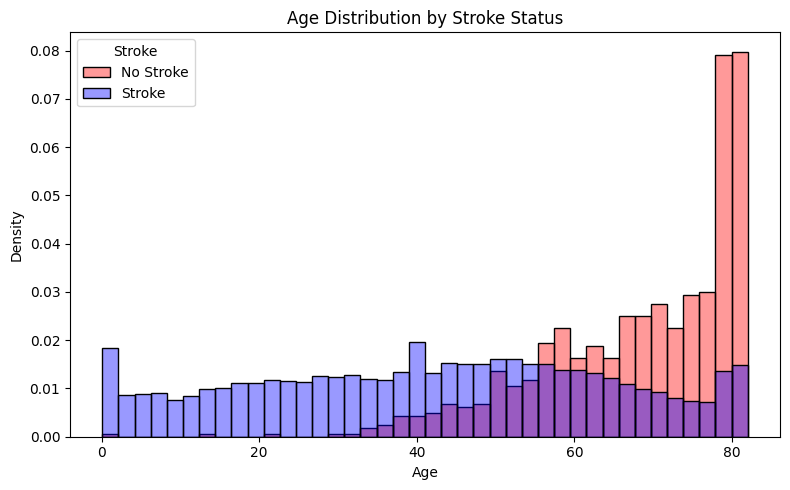

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(data=data2, x='age', hue='stroke', stat='density',
             common_norm=False, palette={0:'blue', 1:'red'}, alpha=0.4)
plt.title('Age Distribution by Stroke Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])
plt.tight_layout()
plt.show()


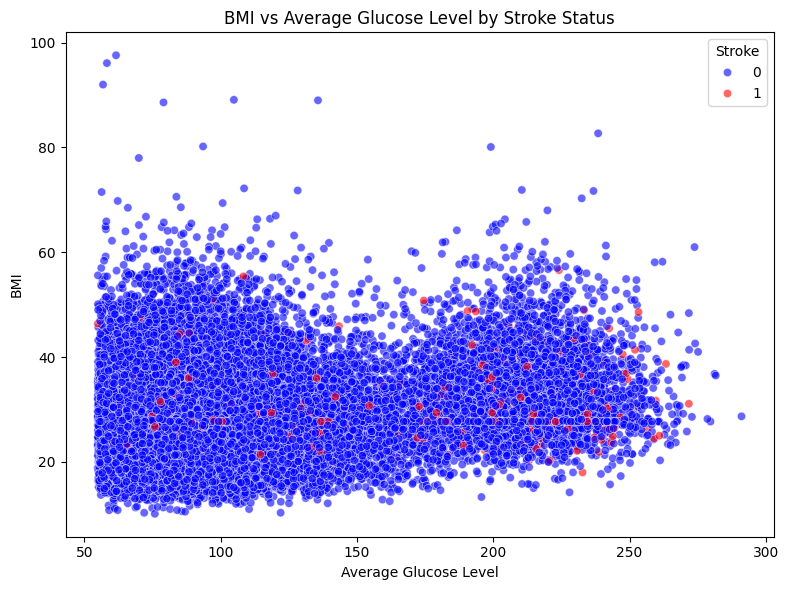

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=data2, x='avg_glucose_level', y='bmi',
                hue='stroke', palette={0:'blue', 1:'red'}, alpha=0.6)
plt.title('BMI vs Average Glucose Level by Stroke Status')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.legend(title='Stroke')
plt.tight_layout()
plt.show()


/tmp/ipython-input-1826815262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stroke_by_smoke.index, y=stroke_by_smoke.values, palette='coolwarm')


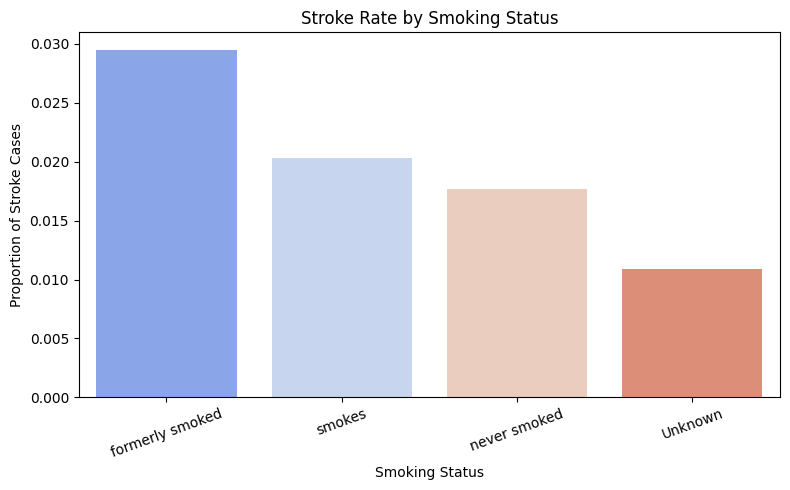

In [ ]:
# Create a smoking_map excluding NaN values
smoking_map = {k: v for k, v in dict(zip(label_enc2.transform(label_enc2.classes_), label_enc2.classes_)).items() if pd.notna(v)}
data2['smoking_status_label'] = data2['smoking_status'].map(smoking_map)  # ✅ Creates a safe copy for graph

stroke_by_smoke = data2.groupby('smoking_status_label')['stroke'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=stroke_by_smoke.index, y=stroke_by_smoke.values, palette='coolwarm')
plt.title('Stroke Rate by Smoking Status')
plt.ylabel('Proportion of Stroke Cases')
plt.xlabel('Smoking Status')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [ ]:
# Droping decoded column before modeling
if 'smoking_status_label' in data2.columns:
    data2 = data2.drop(columns=['smoking_status_label'])

# **Modelling and Evaluation**

In [ ]:
# Step 1: Spliting data2
X2 = data2.drop(columns='stroke')
y2 = data2['stroke']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=1)

# Step 2: Applying SMOTE-ENN
smote_enn_2 = SMOTEENN(random_state=1)
X2_train_res, y2_train_res = smote_enn_2.fit_resample(X2_train, y2_train)

# Step 3: Scaling for Logistic Regression
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train_res)
X2_test_scaled = scaler2.transform(X2_test)

In [ ]:
# Containers for results
model_results2 = []

# Helper function to store metrics
def evaluate_model2(name, y_true, y_pred, y_proba):
    model_results2.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred), 3),
        "Recall": round(recall_score(y_true, y_pred), 3),
        "ROC AUC": round(roc_auc_score(y_true, y_proba), 3)
    })

# Logistic Regression
lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X2_train_scaled, y2_train_res)
y2_pred_lr = lr2.predict(X2_test_scaled)
y2_proba_lr = lr2.predict_proba(X2_test_scaled)[:, 1]
evaluate_model2("Logistic Regression", y2_test, y2_pred_lr, y2_proba_lr)

# Random Forest
rf2 = RandomForestClassifier()
rf2.fit(X2_train_res, y2_train_res)
y2_pred_rf = rf2.predict(X2_test)
y2_proba_rf = rf2.predict_proba(X2_test)[:, 1]
evaluate_model2("Random Forest", y2_test, y2_pred_rf, y2_proba_rf)

# XGBoost
xgb2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb2.fit(X2_train_res, y2_train_res)
y2_pred_xgb = xgb2.predict(X2_test)
y2_proba_xgb = xgb2.predict_proba(X2_test)[:, 1]
evaluate_model2("XGBoost", y2_test, y2_pred_xgb, y2_proba_xgb)

# LightGBM
lgb2 = LGBMClassifier()
lgb2.fit(X2_train_res, y2_train_res)
y2_pred_lgb = lgb2.predict(X2_test)
y2_proba_lgb = lgb2.predict_proba(X2_test)[:, 1]
evaluate_model2("LightGBM", y2_test, y2_pred_lgb, y2_proba_lgb)

# CatBoost
cat2 = CatBoostClassifier(verbose=0)
cat2.fit(X2_train_res, y2_train_res)
y2_pred_cat = cat2.predict(X2_test)
y2_proba_cat = cat2.predict_proba(X2_test)[:, 1]
evaluate_model2("CatBoost", y2_test, y2_pred_cat, y2_proba_cat)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:33:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 29360, number of negative: 24839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 54199, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541707 -> initscore=0.167218
[LightGBM] [Info] Start training from score 0.167218



📊 Logistic Regression
Accuracy: 0.928
Precision: 0.7
Recall: 0.538
F1 Score: 0.609
ROC AUC: 0.908


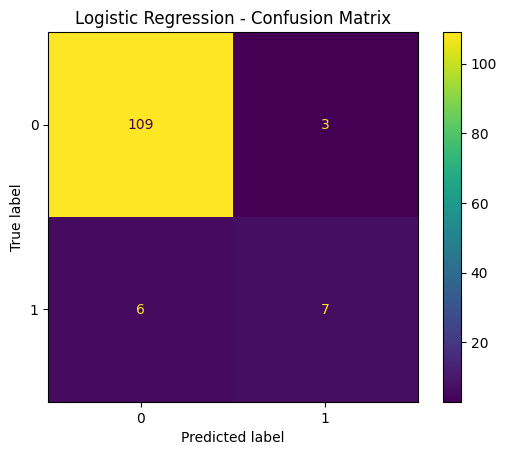

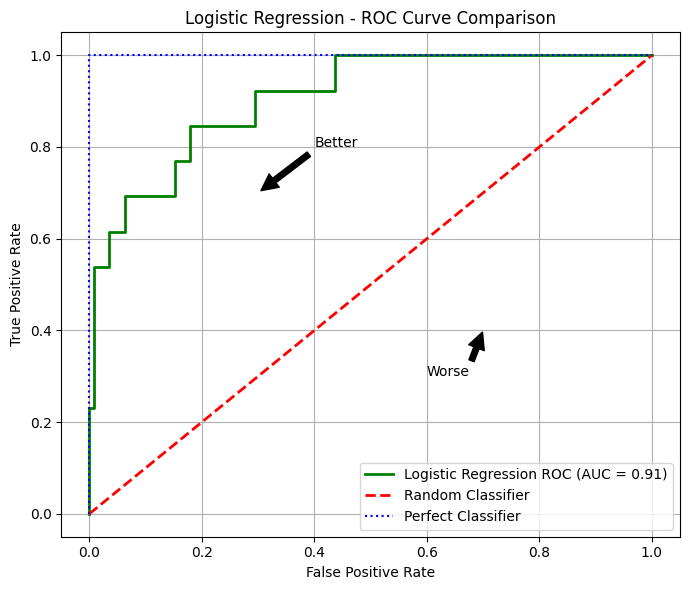


📊 Random Forest
Accuracy: 0.968
Precision: 0.909
Recall: 0.769
F1 Score: 0.833
ROC AUC: 0.99


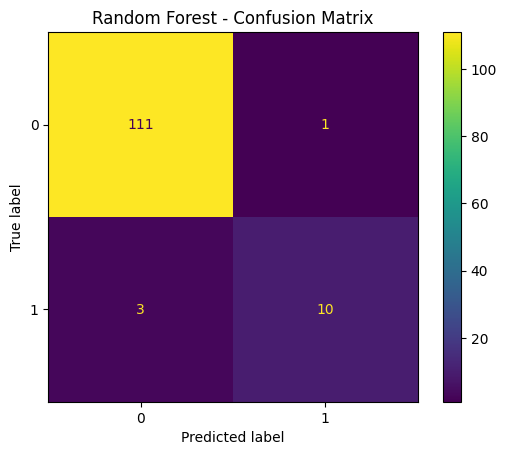

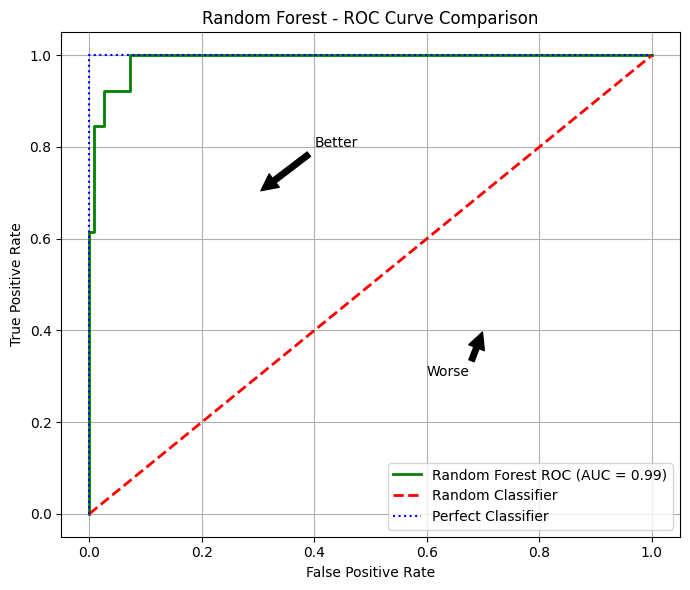


📊 XGBoost
Accuracy: 0.952
Precision: 0.818
Recall: 0.692
F1 Score: 0.75
ROC AUC: 0.992


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:33:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


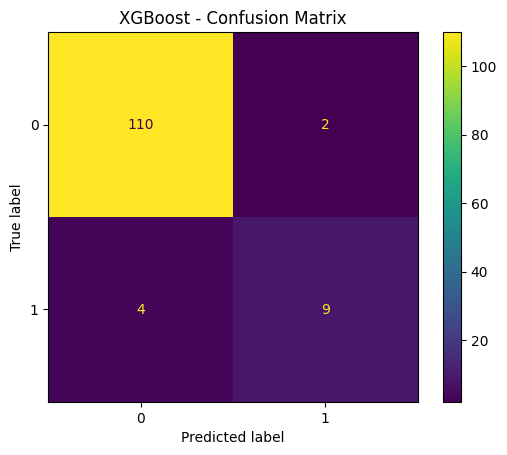

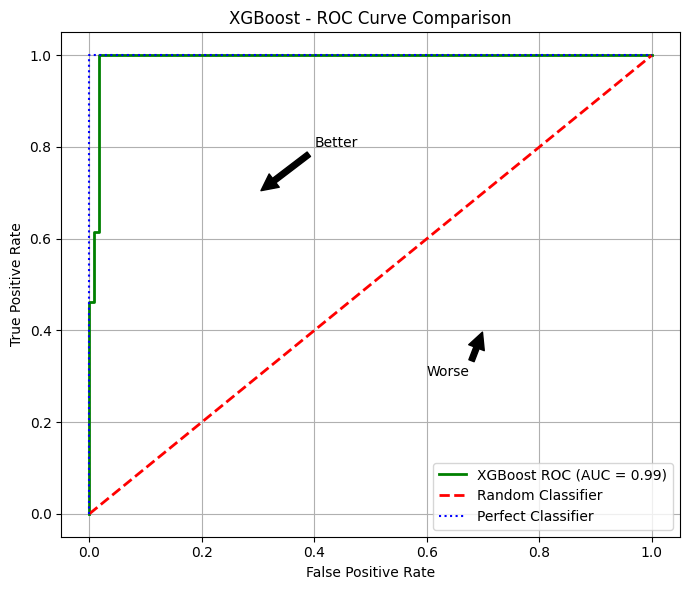

[LightGBM] [Info] Number of positive: 38, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1258
[LightGBM] [Info] Number of data points in the train set: 375, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101333 -> initscore=-2.182497
[LightGBM] [Info] Start training from score -2.182497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


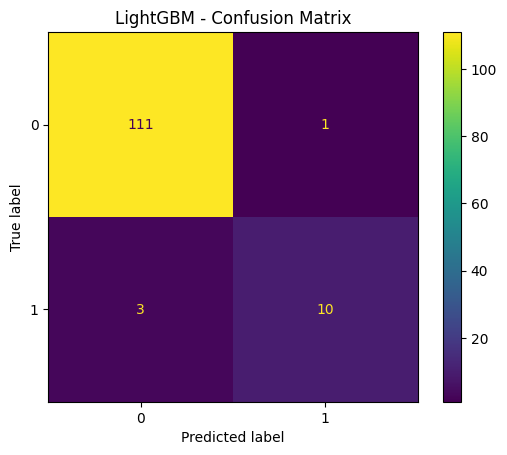

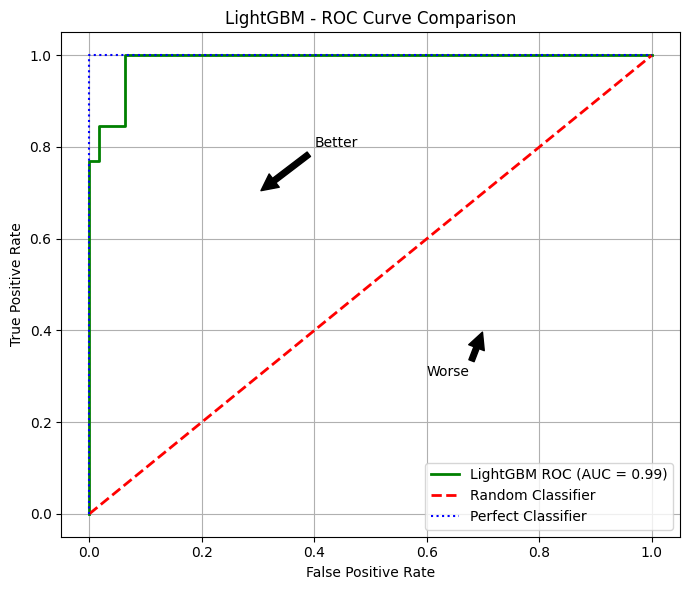


📊 CatBoost
Accuracy: 0.968
Precision: 1.0
Recall: 0.692
F1 Score: 0.818
ROC AUC: 0.994


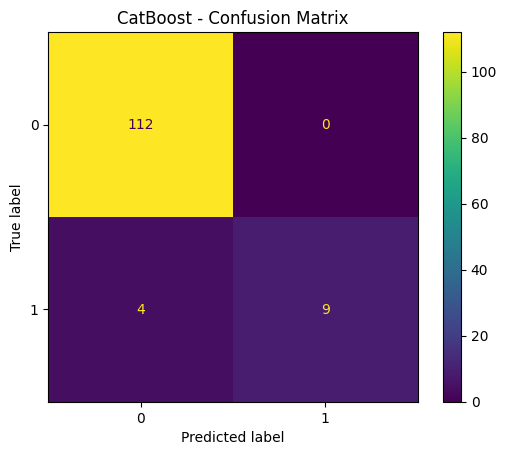

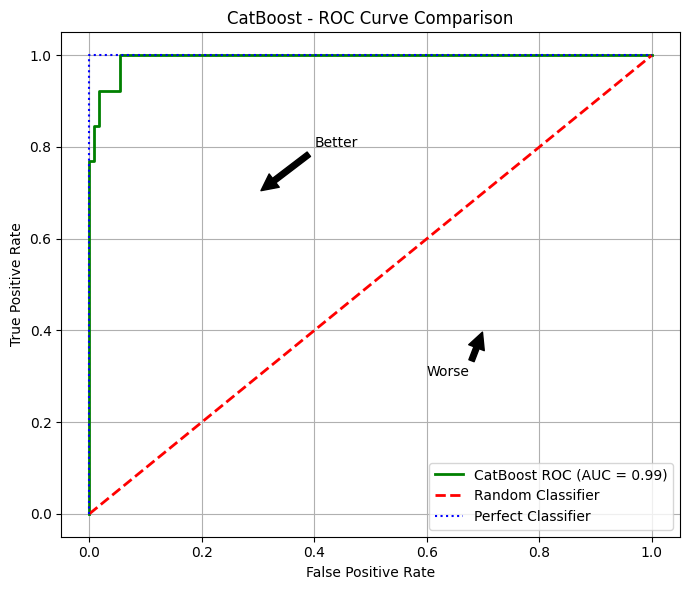

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_classification(n_samples=500, n_features=10, weights=[0.9], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Evaluate and plot each model
for name, model in models.items():
    # Fit and predict
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Printing metrics
    print(f"\n📊 {name}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))
    print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'{name} ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
    plt.plot([0, 0, 1], [0, 1, 1], color='blue', lw=1.5, linestyle=':', label='Perfect Classifier')

    # Annotations
    plt.annotate('Better', xy=(0.3, 0.7), xytext=(0.4, 0.8),
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)
    plt.annotate('Worse', xy=(0.7, 0.4), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

    # Formatting
    plt.title(f"{name} - ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# **Results**

In [ ]:
# Create and display model comparison table for Dataset 2
comparison_df2 = pd.DataFrame(model_results2)
comparison_df2 = comparison_df2.sort_values(by="ROC AUC", ascending=False)
display(comparison_df2)


,Model,Accuracy,Precision,Recall,ROC AUC
0,Logistic Regression,0.728,0.051,0.796,0.828
1,Random Forest,0.931,0.070,0.230,0.809
3,LightGBM,0.873,0.063,0.434,0.802
2,XGBoost,0.904,0.066,0.328,0.787
4,CatBoost,0.934,0.082,0.260,0.783


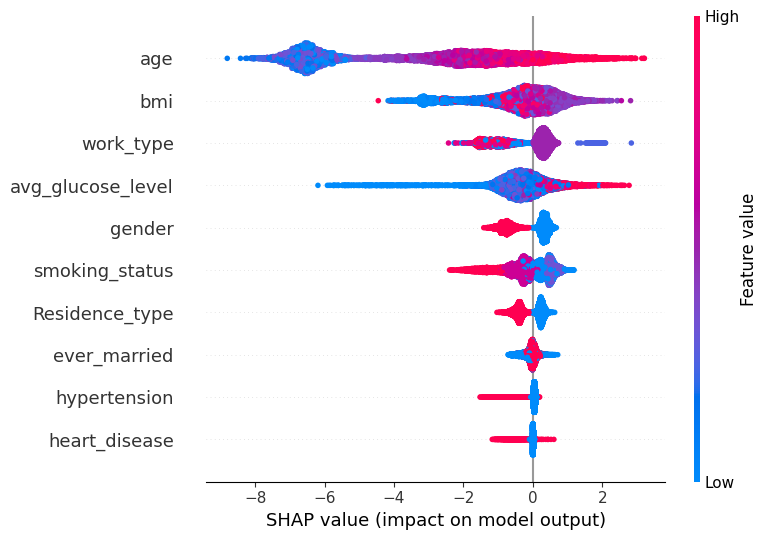

In [ ]:
import shap

# Choose the best model based on comparison (you can change to any model)
best_model2 = cat2

# SHAP for CatBoost
explainer = shap.Explainer(best_model2)
shap_values = explainer(X2_test)

# SHAP summary plot
shap.summary_plot(shap_values, X2_test, feature_names=X2.columns)
